# Joint optimisation of PT headways and DRT fleet sizes

This notebook demonstrates functionality for adding DRT to the optimisation problem. There are a few papers that attempt to do this, see for example: [Joint design of multimodal transit networks and shared autonomous mobility fleets](https://www.sciencedirect.com/science/article/pii/S0968090X18317728)


Specifically, we extend the problem to specify:
- DRT service areas
- Allowable fleet sizes for each service area (Discrete list)

The solution then optimises both PT headways (as before) and DRT fleet sizes based on the objective functions specified.

## Data preparation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT + DRT OPTIMIZATION TEST ===")
print("🚀 Testing PT+DRT optimization functionality")
print("📊 This notebook will test the new DRT fleet sizing capabilities")

logging.basicConfig(level=logging.INFO)

=== TRANSIT + DRT OPTIMIZATION TEST ===
🚀 Testing PT+DRT optimization functionality
📊 This notebook will test the new DRT fleet sizing capabilities


### Load GTFS Data and Study Boundary

In [2]:
# Cell 2: Load GTFS Data and Study Boundary
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== GTFS DATA LOADING ===")

# Create GTFS preparator (same settings as 2a_optimisation_basic.ipynb)
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day (like basic notebook)
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"
)

# Define allowed headways for PT optimization (same as basic notebook)
allowed_headways = [10, 15, 30, 60, 120, 240]  # in minutes

print(f"📋 Allowed PT headways: {allowed_headways} minutes")


2025-10-22 17:04:27,298 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 6h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 6h intervals
2025-10-22 17:04:27,300 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip



=== GTFS DATA LOADING ===


2025-10-22 17:04:29,689 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
INFO:transit_opt.preprocessing.prepare_gtfs:Using full GTFS feed (all service periods)
2025-10-22 17:04:31,420 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 4.12 seconds
INFO:transit_opt.preprocessing.prepare_gtfs:GTFS loaded and cached in 4.12 seconds
2025-10-22 17:04:31,422 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
INFO:transit_opt.preprocessing.prepare_gtfs:Dataset: 13,974 trips, 703,721 stop times


📋 Allowed PT headways: [10, 15, 30, 60, 120, 240] minutes


In [3]:
print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry (same as basic notebook)
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===
📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Configure DRT Services

We use a config to define DRT service areas and fleet size options.
DRT service areas should be shapefiles defining a geographic polygon. The polygons should overlap with the study area boundary / public transport network bounding box

You need to set 'enabled' to True to include DRT in the optimisation. Otherwise, the optimisation will only consider PT headways as before.
`drt_speed_kmh` defines the average speed of DRT vehicles in km/h. It is used to estimate how drt fleet size affects waiting times and coverage. See how this is done in spatial/zoning.py (_calculate_drt_vehicles_by_interval) ... logic can definitely be improved. 

In [4]:
print("\n=== DRT CONFIGURATION ===")

# DRT configuration
drt_config = {
    'enabled': True,
    'target_crs': 'EPSG:3857',  # Web Mercator for consistency
    'default_drt_speed_kmh': 25.0,  # Default speed for all DRT zones
    'zones': [
        {
            'zone_id': 'drt_ne',
            'service_area_path': '../data/external/drt/drt_ne.shp',
            'allowed_fleet_sizes': [0, 10, 25, 50, 100],  # Fleet options for this zone
            'zone_name': 'Leeds NE DRT',
            'drt_speed_kmh': 20.0  # Zone-specific speed (campus area - slower)
        },
        {
            'zone_id': 'drt_nw',
            'service_area_path': '../data/external/drt/drt_nw.shp',
            'allowed_fleet_sizes': [0, 15, 30, 60, 120],  # Different fleet options
            'zone_name': 'Leeds NW DRT'
            # Will use default_drt_speed_kmh (25.0) since zone-specific not provided
        }
    ]
}

print("🚁 DRT Configuration:")
print(f"   Default speed: {drt_config['default_drt_speed_kmh']} km/h")
print(f"   Number of DRT zones: {len(drt_config['zones'])}")

for zone in drt_config['zones']:
    fleet_options = zone['allowed_fleet_sizes']
    speed = zone.get('drt_speed_kmh', drt_config['default_drt_speed_kmh'])
    print(f"   • {zone['zone_name']}: {len(fleet_options)} fleet options {fleet_options}, speed {speed} km/h")


=== DRT CONFIGURATION ===
🚁 DRT Configuration:
   Default speed: 25.0 km/h
   Number of DRT zones: 2
   • Leeds NE DRT: 5 fleet options [0, 10, 25, 50, 100], speed 20.0 km/h
   • Leeds NW DRT: 5 fleet options [0, 15, 30, 60, 120], speed 25.0 km/h


### Load in PT+DRT Optimization Data

In [5]:
print("\n=== EXTRACTING PT+DRT OPTIMIZATION DATA ===")

# Extract optimization data with DRT support
opt_data = preparator.extract_optimization_data_with_drt(
    allowed_headways=allowed_headways, 
    drt_config=drt_config
)

print(f"\n✅ PT+DRT OPTIMIZATION DATA EXTRACTED:")
print(f"   📊 PT Routes: {opt_data['n_routes']}")
print(f"   🚁 DRT Zones: {opt_data['n_drt_zones']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']} min each)")
print(f"   🎯 Total decision variables: {opt_data['total_decision_variables']}")
print(f"      • PT variables: {opt_data['pt_decision_variables']}")
print(f"      • DRT variables: {opt_data['drt_decision_variables']}")
print(f"   🔢 PT headway choices: {opt_data['n_choices']}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")

# Verify DRT zones loaded correctly
print(f"\n🗺️ DRT SPATIAL DATA:")
for zone in opt_data['drt_config']['zones']:
    print(f"   Zone {zone['zone_id']}: {zone['area_km2']:.2f} km², speed {zone['drt_speed_kmh']} km/h")

2025-10-22 17:04:32,794 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 6 allowed headways
INFO:transit_opt.preprocessing.prepare_gtfs:Extracting optimization data with 6 allowed headways
2025-10-22 17:04:32,796 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 6-hour intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Extracting route essentials with 6-hour intervals



=== EXTRACTING PT+DRT OPTIMIZATION DATA ===
🔧 EXTRACTING OPTIMIZATION DATA WITH DRT SUPPORT:


2025-10-22 17:04:34,929 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73302: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-10-22 17:04:35,000 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 54721: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-10-22 17:04:36,837 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 30922: Round-trip 247.2min exceeds limit (240.0min), filtered out
2025-10-22 17:04:37,542 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 12490: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-10-22 17:04:37,622 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 37599: Round-trip 355.3min exceeds limit (240.0min), filtered out
2025-10-22 17:04:40,116 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 59129: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-10-22 17:04:43,115 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73828: Round-trip 258.8

   ✅ Base PT data extracted: 147 routes, 4 intervals
   🚁 Adding DRT configuration...
   🔍 Validating DRT configuration...
   ✅ DRT configuration valid: 2 zones
      Target CRS: EPSG:3857
   🗺️ Loading DRT spatial layers...
      Target CRS: EPSG:3857
      Loading zone 1: drt_ne
         Path: ../data/external/drt/drt_ne.shp
         Original CRS: EPSG:3857
         🔄 Converting: EPSG:3857 → EPSG:3857
   DRT Zone drt_ne: 474.95 km², speed 20.0 km/h
         ✅ Loaded: 474.95 km² service area
            CRS: EPSG:3857
            Fleet choices: [0, 10, 25, 50, 100]
      Loading zone 2: drt_nw
         Path: ../data/external/drt/drt_nw.shp
         Original CRS: EPSG:3857
         🔄 Converting: EPSG:3857 → EPSG:3857
   DRT Zone drt_ne: 474.95 km², speed 20.0 km/h
   DRT Zone drt_nw: 151.69 km², speed 25.0 km/h
         ✅ Loaded: 151.69 km² service area
            CRS: EPSG:3857
            Fleet choices: [0, 15, 30, 60, 120]
   ✅ All DRT spatial layers loaded successfully
      Total

## Test Objectives on combined PT + DRT vehicle data

Let's first verify that the objective functions can properly calculate objectives using the combined PT + DRT data structure, and that the data can be decoded correctly. Encoding/Decoding is essential in the PSO optimisation process in pymoo 

In [6]:
print("\n=== TESTING PROBLEM SETUP ===")

from transit_opt.optimisation.problems.transit_problem import TransitOptimizationProblem
from transit_opt.optimisation.objectives.service_coverage import HexagonalCoverageObjective

# Create objective (same as basic notebook)
coverage_objective = HexagonalCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,      # 2km diameter hexagons
    crs="EPSG:3857",                # Web Mercator (metric CRS)
    boundary=study_boundary,        # Filter to study area only
    time_aggregation="average",     # Average service across time intervals
    spatial_lag=False               # Standard variance (no neighbor effects)
)

print(f"✅ Coverage objective created:")
print(f"   Hexagonal zones: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   Transit stops: {len(coverage_objective.spatial_system.stops_gdf)}")

# Create problem with DRT support
problem = TransitOptimizationProblem(
    optimization_data=opt_data,
    objective=coverage_objective
)

print(f"\n✅ OPTIMIZATION PROBLEM CREATED:")
print(f"   Problem variables: {problem.n_var}")
print(f"   DRT enabled: {problem.drt_enabled}")
print(f"   Variable bounds: 0 to {max(problem.xu)}")

# Test solution decoding
print(f"\n🔧 TESTING SOLUTION DECODING:")
decoded_solution = problem.decode_solution(opt_data['initial_solution'])

if problem.drt_enabled:
    print(f"   PT matrix shape: {decoded_solution['pt'].shape}")
    print(f"   DRT matrix shape: {decoded_solution['drt'].shape}")
    print(f"   DRT initial fleet choices (first 5): {decoded_solution['drt'].flatten()[:5]}")
    
    # Show what fleet sizes this corresponds to
    print(f"\n🚁 INITIAL DRT FLEET ASSIGNMENTS:")
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones']):
        for interval_idx in range(decoded_solution['drt'].shape[1]):
            fleet_choice_idx = decoded_solution['drt'][zone_idx, interval_idx]
            fleet_size = zone['allowed_fleet_sizes'][fleet_choice_idx]
            interval_label = opt_data['intervals']['labels'][interval_idx]
            print(f"   {zone['zone_id']} - {interval_label}: choice {fleet_choice_idx} = {fleet_size} vehicles")
else:
    print(f"   PT matrix shape: {decoded_solution.shape}")


=== TESTING PROBLEM SETUP ===
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🗺️ Computing DRT spatial intersections for 2 zones...
   Hexagonal grid size: 552 zones
   Zone drt_ne: affects 149 hexagonal zones
   Zone drt_nw: affects 54 hexagonal zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones
✅ Coverage objective created:
   Hexagonal zones: 552
   Transit stops: 4405
🏗️  CREATING TRANSIT OPTIM

In [7]:
print("\n=== TESTING OBJECTIVE EVALUATION ===")

# Evaluate coverage objective on initial solution
if opt_data['drt_enabled']:
    # For DRT-enabled problems, objective currently only uses PT part
    pt_solution_matrix = decoded_solution['pt']
    baseline_coverage_value = coverage_objective.evaluate(pt_solution_matrix)
else:
    baseline_coverage_value = coverage_objective.evaluate(opt_data['initial_solution'])

print(f"✅ BASELINE COVERAGE EVALUATION:")
print(f"   Objective value (variance): {baseline_coverage_value:.6f}")

# Get detailed analysis
coverage_analysis = coverage_objective.get_detailed_analysis(decoded_solution['pt'])
print(f"   Zones with service: {coverage_analysis['zones_with_service_average']}/{len(coverage_objective.spatial_system.hex_grid)}")
print(f"   Mean vehicles per zone: {coverage_analysis['total_vehicles_average']:.2f}")
print(f"   Standard deviation: {coverage_analysis['std_dev_average']:.3f}")
print(f"   Coefficient of variation: {coverage_analysis['coefficient_of_variation_average']:.3f}")


=== TESTING OBJECTIVE EVALUATION ===
📊 Calculating PT-only vehicles per zone...
📊 Vehicles per zone (average): min=0.0, max=650.75, var=3325.22
✅ BASELINE COVERAGE EVALUATION:
   Objective value (variance): 3325.215462
📊 Calculating PT-only vehicles per zone...
   Zones with service: 347/552
   Mean vehicles per zone: 14634.00
   Standard deviation: 57.665
   Coefficient of variation: 2.175


## Run PSO with combined PT + DRT solution space

The PSO optimisation should now be able to search both PT headways and DRT fleet sizes simultaneously. The output should be a combined solution.
- pt: a matrix of shape (num_routes, num_intervals) representing the headway value for each route in each time interval.
- drt: a matrix of shape (num_drt_areas, num_intervals) representing the fleet size for each DRT area in each time interval.

### Objective A: Minimise variance in Service Coverage

In [8]:
# Cell 7: Test DRT-Optimized PSO Run
print("\n=== RUNNING PT+DRT OPTIMIZATION ===")

# Configuration for PT+DRT optimization (similar to basic notebook)
config_drt_coverage = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 2.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'time_aggregation': 'average'
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,  # 35% increase allowed for PT
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.85,  # Maintain 85% of current PT service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,         # Smaller population for faster testing
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 25},  # Fewer generations for testing
        'monitoring': {'progress_frequency': 5, 'save_history': False}
    }
}

from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

print(f"🚀 OPTIMIZATION CONFIGURATION:")
print(f"   Algorithm: PSO with {config_drt_coverage['optimization']['algorithm']['pop_size']} particles")
print(f"   Generations: {config_drt_coverage['optimization']['termination']['max_generations']}")
print(f"   Objective: Spatial equity (minimize variance)")
print(f"   DRT zones: {opt_data['n_drt_zones']} with fleet optimization")

config_manager_drt = OptimizationConfigManager(config_dict=config_drt_coverage)
pso_runner_drt = PSORunner(config_manager_drt)

# Run optimization
result_drt_coverage = pso_runner_drt.optimize(opt_data, track_best_n=3)

print(f"\n✅ PT+DRT OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_drt_coverage.optimization_time:.1f} seconds")
print(f"   Generations completed: {result_drt_coverage.generations_completed}")
print(f"   Best objective: {result_drt_coverage.best_objective:.6f}")
print(f"   Baseline objective: {baseline_coverage_value:.6f}")
print(f"   Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")
print(f"   Feasible solution: {'✅ Yes' if result_drt_coverage.constraint_violations['feasible'] else '❌ No'}")

if not result_drt_coverage.constraint_violations['feasible']:
    print("   ⚠️ Constraint violations:")
    for detail in result_drt_coverage.constraint_violations['violation_details']:
        if detail['violation'] < -0.001:
            print(f"      • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")


=== RUNNING PT+DRT OPTIMIZATION ===
🚀 OPTIMIZATION CONFIGURATION:
   Algorithm: PSO with 35 particles
   Generations: 25
   Objective: Spatial equity (minimize variance)
   DRT zones: 2 with fleet optimization
📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🗺️ Computing DRT spatial intersections for 2 zones...
   Hexagonal grid size: 552 zones
   Zone drt_ne: affects 149 hexagonal zones
   Zone d

In [9]:
result_drt_coverage.best_solution

{'pt': array([[0, 5, 5, 5],
        [1, 5, 3, 5],
        [5, 4, 3, 5],
        [0, 0, 0, 3],
        [3, 1, 4, 3],
        [2, 3, 5, 0],
        [4, 1, 4, 1],
        [2, 1, 1, 2],
        [2, 3, 2, 4],
        [3, 0, 4, 0],
        [5, 2, 2, 3],
        [4, 4, 2, 5],
        [0, 4, 3, 3],
        [5, 3, 4, 4],
        [5, 0, 5, 2],
        [5, 5, 3, 3],
        [5, 0, 5, 2],
        [1, 5, 0, 2],
        [5, 2, 2, 3],
        [5, 4, 0, 4],
        [5, 3, 2, 1],
        [5, 5, 0, 0],
        [1, 1, 1, 5],
        [0, 0, 2, 2],
        [3, 4, 0, 3],
        [4, 4, 4, 0],
        [2, 3, 2, 0],
        [0, 0, 2, 5],
        [3, 4, 4, 4],
        [2, 0, 4, 3],
        [0, 0, 0, 5],
        [1, 1, 3, 1],
        [1, 3, 3, 3],
        [5, 0, 5, 0],
        [5, 4, 3, 2],
        [4, 0, 4, 0],
        [4, 3, 0, 2],
        [1, 4, 5, 2],
        [1, 5, 4, 3],
        [4, 0, 2, 2],
        [4, 5, 1, 3],
        [2, 2, 1, 4],
        [1, 4, 5, 5],
        [0, 0, 3, 4],
        [5, 4, 5, 4],
    

#### Analyse Results

Look at how DRT fleet size was allocated across zones and time intervals

In [10]:
print("\n=== ANALYZING OPTIMIZED DRT DEPLOYMENT ===")

# Decode the optimized solution
optimized_solution = result_drt_coverage.best_solution

print(f"🔍 OPTIMIZED SOLUTION ANALYSIS:")
print(f"   PT matrix shape: {optimized_solution['pt'].shape}")
print(f"   DRT matrix shape: {optimized_solution['drt'].shape}")

# Analyze DRT deployment changes
print(f"\n🚁 DRT FLEET DEPLOYMENT COMPARISON:")
print(f"{'Zone':<15} {'Interval':<12} {'Initial':<8} {'Optimized':<10} {'Change':<8}")
print("-" * 60)

for zone_idx, zone in enumerate(opt_data['drt_config']['zones']):
    for interval_idx in range(optimized_solution['drt'].shape[1]):
        # Initial deployment
        initial_choice_idx = decoded_solution['drt'][zone_idx, interval_idx]
        initial_fleet_size = zone['allowed_fleet_sizes'][initial_choice_idx]
        
        # Optimized deployment
        optimized_choice_idx = optimized_solution['drt'][zone_idx, interval_idx]
        optimized_fleet_size = zone['allowed_fleet_sizes'][optimized_choice_idx]
        
        # Calculate change
        change = optimized_fleet_size - initial_fleet_size
        change_str = f"{change:+d}" if change != 0 else "0"
        
        interval_label = opt_data['intervals']['labels'][interval_idx]
        zone_short = zone['zone_id'].replace('drt_duke_', 'Duke')
        
        print(f"{zone_short:<15} {interval_label:<12} {initial_fleet_size:<8} {optimized_fleet_size:<10} {change_str:<8}")

# Calculate total DRT fleet changes
initial_drt_total = np.sum([
    zone['allowed_fleet_sizes'][choice_idx] 
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones'])
    for interval_idx in range(decoded_solution['drt'].shape[1])
    for choice_idx in [decoded_solution['drt'][zone_idx, interval_idx]]
])

optimized_drt_total = np.sum([
    zone['allowed_fleet_sizes'][choice_idx] 
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones'])
    for interval_idx in range(optimized_solution['drt'].shape[1])
    for choice_idx in [optimized_solution['drt'][zone_idx, interval_idx]]
])

print(f"\n📊 TOTAL DRT FLEET SUMMARY:")
print(f"   Initial total DRT vehicles: {initial_drt_total}")
print(f"   Optimized total DRT vehicles: {optimized_drt_total}")
print(f"   DRT fleet change: {optimized_drt_total - initial_drt_total:+d} vehicles")


=== ANALYZING OPTIMIZED DRT DEPLOYMENT ===
🔍 OPTIMIZED SOLUTION ANALYSIS:
   PT matrix shape: (147, 4)
   DRT matrix shape: (2, 4)

🚁 DRT FLEET DEPLOYMENT COMPARISON:
Zone            Interval     Initial  Optimized  Change  
------------------------------------------------------------
drt_ne          00-06h       0        100        +100    
drt_ne          06-12h       0        100        +100    
drt_ne          12-18h       0        10         +10     
drt_ne          18-24h       0        50         +50     
drt_nw          00-06h       0        0          0       
drt_nw          06-12h       0        0          0       
drt_nw          12-18h       0        30         +30     
drt_nw          18-24h       0        0          0       

📊 TOTAL DRT FLEET SUMMARY:
   Initial total DRT vehicles: 0
   Optimized total DRT vehicles: 290
   DRT fleet change: +290 vehicles


#### Basic Plot of vehicles per zone in best objective

📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 1 (06-12h)
   Peak total vehicles: 20554.0


/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:953: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:953: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:953: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s

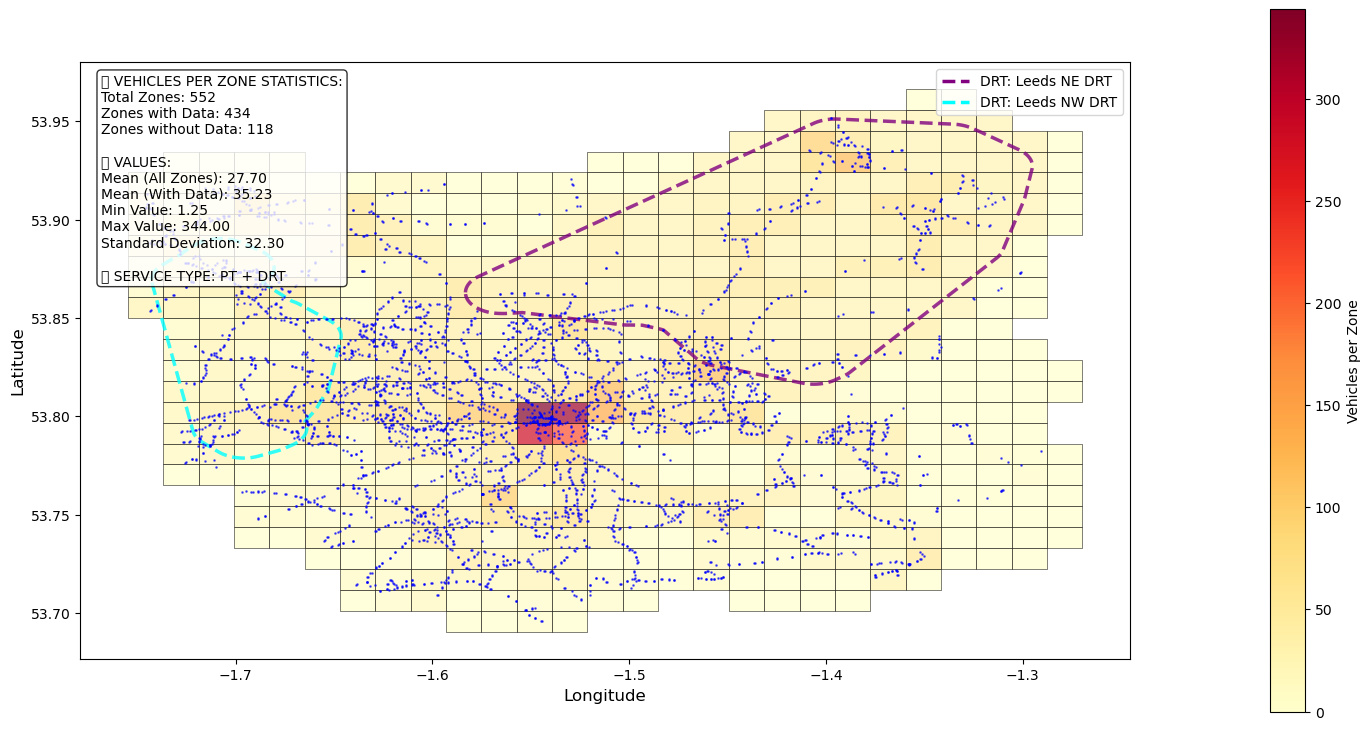

(<Figure size 1500x1200 with 2 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [11]:
coverage_objective.visualize(
    solution_matrix=optimized_solution,
    #optimization_data=opt_data,
    show_stops=True,
    show_drt_zones=True
)

#### Visualise service coverage and waiting times

We compare the service coverage and waiting times before and after optimisation to see how they have changed. The DRT service area polygons are overlaid on the maps to show where DRT is operating.



=== COMPREHENSIVE SPATIAL COVERAGE ANALYSIS ===
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT-only vehicles per zone...
📊 SPATIAL EQUITY IMPROVEMENTS:
   Objective Value:
     Baseline: 3325.215462
     Optimized: 1043.774951
     Improvement: +68.6%

   Service Coverage:
     Zones with service: 347 → 348 (+1)
     Mean vehicles/zone: 14634.00 → 10825.50

   Service Distribution:
     Variance: 3325.215462 → 1043.774951 (-68.6%)
     Coefficient of variation: 2.175 → 1.647
🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundar

/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting optimized solutions...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 1 (06-12h)
   Peak total vehicles: 20554.0


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 1 (06-12h)
   Peak total vehicles: 20554.0


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting improvement differences...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

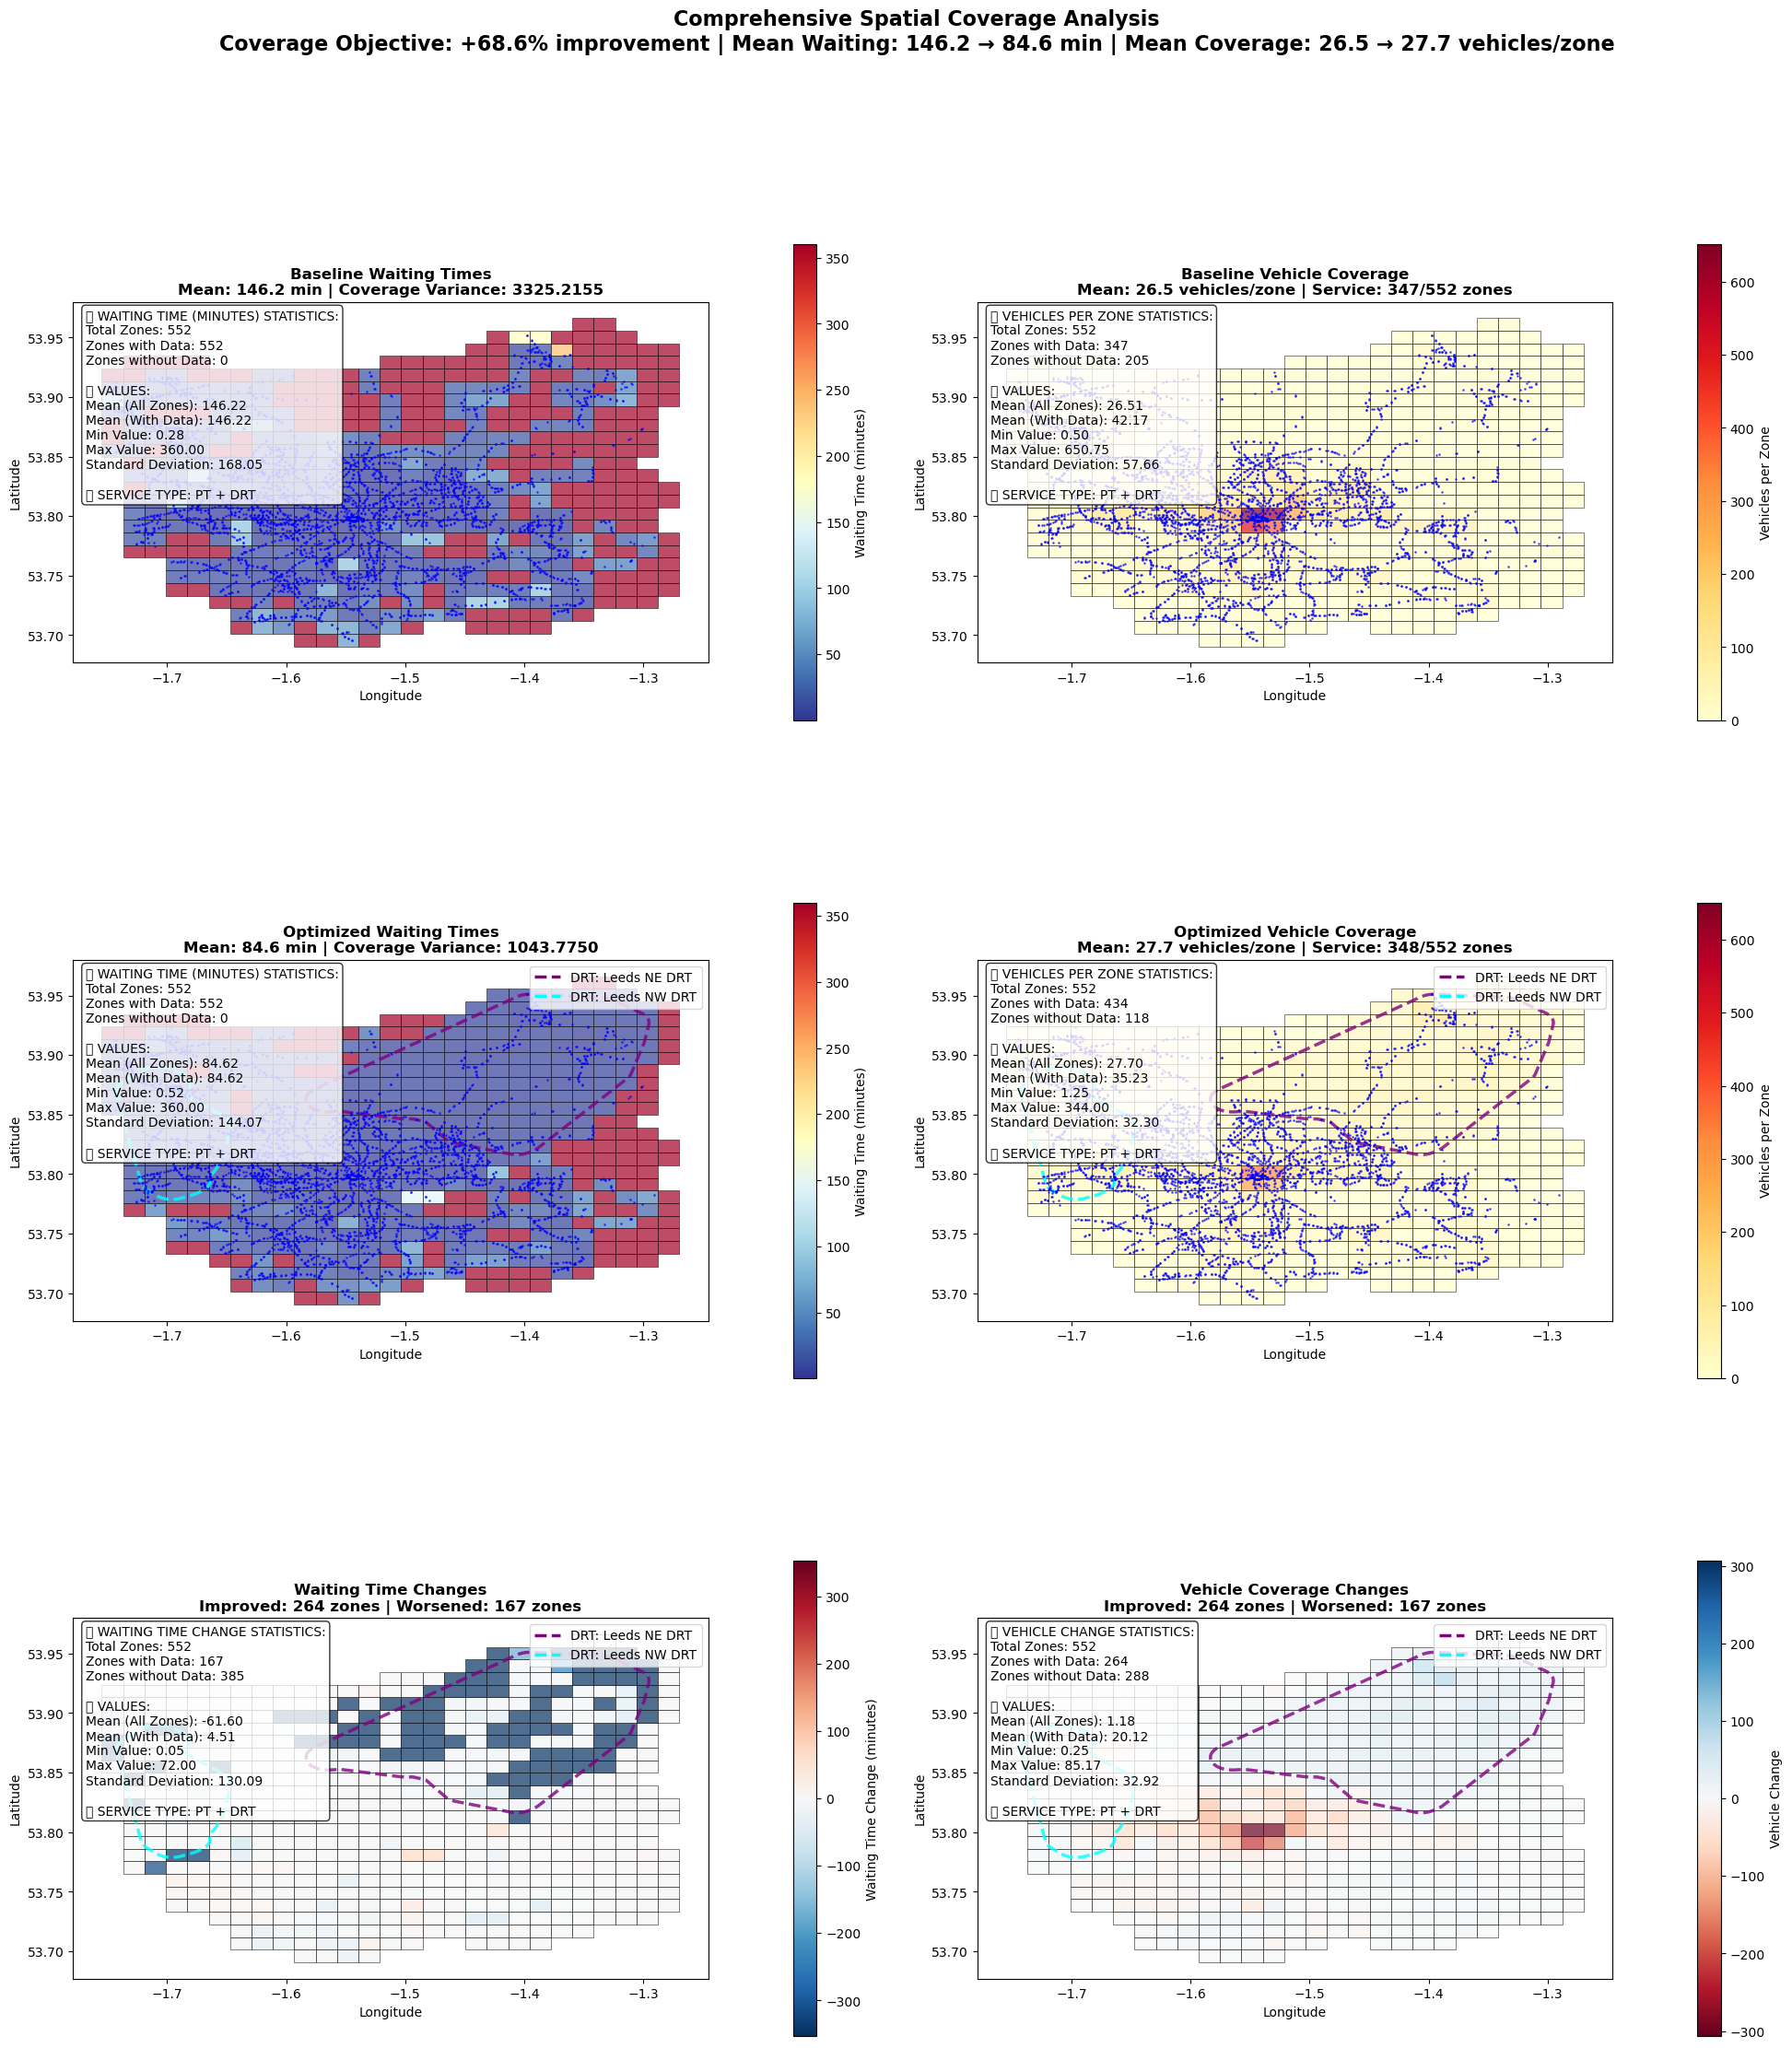


📊 COMPREHENSIVE SPATIAL COVERAGE ANALYSIS SUMMARY:
   🎯 Primary Objective (Spatial Coverage Variance):
      Baseline: 3325.215462 → Optimized: 1043.774951
      Improvement: +68.6%

   ⏱️ Waiting Time Distribution:
      Mean: 146.22 → 84.62 minutes (-61.60)
      Zones with improved waiting: 264/552 (47.8%)

   🚌 Vehicle Coverage Distribution:
      Mean: 26.51 → 27.70 vehicles/zone (+1.18)
      Zones with more vehicles: 264/552 (47.8%)

   📍 Service Coverage:
      Zones with service: 347 → 348 (+1)
      Service coverage: 62.9% → 63.0%

   🏆 Trade-offs Analysis:
      ✅ Win-Win: Both waiting times decreased AND vehicle coverage increased

✅ Comprehensive spatial coverage analysis completed!
   📈 Top row: Baseline solutions
   📈 Middle row: Optimized solutions
   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)
   🚁 DRT zones shown in optimized and difference plots
   ✔️ Solution satisfies constraints: True
   • Spatial equity improved by +68.6%


In [12]:
print("\n=== COMPREHENSIVE SPATIAL COVERAGE ANALYSIS ===")

# Get spatial coverage for baseline and optimized solutions
baseline_coverage_analysis = coverage_objective.get_detailed_analysis(decoded_solution['pt'])
optimized_coverage_analysis = coverage_objective.get_detailed_analysis(optimized_solution['pt'])

print(f"📊 SPATIAL EQUITY IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_coverage_value:.6f}")
print(f"     Optimized: {result_drt_coverage.best_objective:.6f}")
print(f"     Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")

print(f"\n   Service Coverage:")
print(f"     Zones with service: {baseline_coverage_analysis['zones_with_service_average']} → {optimized_coverage_analysis['zones_with_service_average']} ({optimized_coverage_analysis['zones_with_service_average'] - baseline_coverage_analysis['zones_with_service_average']:+d})")
print(f"     Mean vehicles/zone: {baseline_coverage_analysis['total_vehicles_average']:.2f} → {optimized_coverage_analysis['total_vehicles_average']:.2f}")

print(f"\n   Service Distribution:")
print(f"     Variance: {baseline_coverage_analysis['variance_average']:.6f} → {optimized_coverage_analysis['variance_average']:.6f} ({((optimized_coverage_analysis['variance_average'] - baseline_coverage_analysis['variance_average']) / baseline_coverage_analysis['variance_average'] * 100):+.1f}%)")
print(f"     Coefficient of variation: {baseline_coverage_analysis['coefficient_of_variation_average']:.3f} → {optimized_coverage_analysis['coefficient_of_variation_average']:.3f}")

# Calculate waiting times (for column 1) - need to create waiting time objective
from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective

# Create temporary waiting time objective for visualization
temp_waiting_objective = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,
    boundary=study_boundary,
    metric="variance",
    crs="EPSG:3857",
    time_aggregation="average",
    population_weighted=False
)

# Calculate waiting times for both solutions
baseline_waiting_times = temp_waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = temp_waiting_objective.get_waiting_times_per_zone(optimized_solution, "average")

# Calculate spatial coverage (for column 2)
baseline_vehicles = coverage_objective.spatial_system._vehicles_per_zone(decoded_solution['pt'], opt_data)['average']
optimized_vehicles = coverage_objective.spatial_system._vehicles_per_zone(optimized_solution, opt_data)['average']

# Calculate differences
waiting_difference = optimized_waiting_times - baseline_waiting_times  # Negative = improvement
vehicle_difference = optimized_vehicles - baseline_vehicles  # Positive = improvement

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
baseline_mean_vehicles = np.mean(baseline_vehicles)
optimized_mean_vehicles = np.mean(optimized_vehicles)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} min")

print(f"\n   Vehicle Coverage Distribution:")
print(f"     Mean vehicles/zone: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f}")
print(f"     Change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")

# Determine shared color scales for fair comparison
waiting_vmin = min(baseline_waiting_times.min(), optimized_waiting_times.min())
waiting_vmax = max(baseline_waiting_times.max(), optimized_waiting_times.max())
vehicle_vmin = min(baseline_vehicles.min(), optimized_vehicles.min())
vehicle_vmax = max(baseline_vehicles.max(), optimized_vehicles.max())

# For difference plots, use symmetric scale around zero
waiting_diff_max = max(abs(waiting_difference.min()), abs(waiting_difference.max()))
vehicle_diff_max = max(abs(vehicle_difference.min()), abs(vehicle_difference.max()))

print(f"\n🎨 COLOR SCALES:")
print(f"   Waiting times: {waiting_vmin:.1f} - {waiting_vmax:.1f} minutes")
print(f"   Vehicle coverage: {vehicle_vmin:.1f} - {vehicle_vmax:.1f}")
print(f"   Waiting differences: ±{waiting_diff_max:.1f} minutes")
print(f"   Vehicle differences: ±{vehicle_diff_max:.1f}")

# Create comprehensive 3x2 visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# Configure overall title
overall_title = (
    f"Comprehensive Spatial Coverage Analysis\n"
    f"Coverage Objective: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}% improvement | "
    f"Mean Waiting: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} min | "
    f"Mean Coverage: {baseline_mean_vehicles:.1f} → {optimized_mean_vehicles:.1f} vehicles/zone"
)
fig.suptitle(overall_title, fontsize=16, fontweight='bold', y=0.995)

# Row 1: Baseline Solutions
print("\n📍 Plotting baseline solutions...")

# Row 1, Col 1: Baseline Waiting Times
temp_waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 0],
    show_stops=True,
    show_drt_zones=False,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[0, 0].set_title(f'Baseline Waiting Times\nMean: {baseline_mean_waiting:.1f} min | Coverage Variance: {baseline_coverage_value:.4f}', 
                     fontsize=12, fontweight='bold')

# Row 1, Col 2: Baseline Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 1],
    show_stops=True,
    show_drt_zones=False,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
zones_with_service = baseline_coverage_analysis['zones_with_service_average']
total_zones = len(coverage_objective.spatial_system.hex_grid)
axes[0, 1].set_title(f'Baseline Vehicle Coverage\nMean: {baseline_mean_vehicles:.1f} vehicles/zone | Service: {zones_with_service}/{total_zones} zones', 
                     fontsize=12, fontweight='bold')

# Row 2: Optimized Solutions
print("📍 Plotting optimized solutions...")

# Row 2, Col 1: Optimized Waiting Times
temp_waiting_objective.visualize(
    solution_matrix=optimized_solution,
    ax=axes[1, 0],
    show_stops=True,
    show_drt_zones=True,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[1, 0].set_title(f'Optimized Waiting Times\nMean: {optimized_mean_waiting:.1f} min | Coverage Variance: {result_drt_coverage.best_objective:.4f}', 
                     fontsize=12, fontweight='bold')

# Row 2, Col 2: Optimized Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=optimized_solution,
    ax=axes[1, 1],
    show_stops=True,
    show_drt_zones=True,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
optimized_zones_with_service = optimized_coverage_analysis['zones_with_service_average']
axes[1, 1].set_title(f'Optimized Vehicle Coverage\nMean: {optimized_mean_vehicles:.1f} vehicles/zone | Service: {optimized_zones_with_service}/{total_zones} zones', 
                     fontsize=12, fontweight='bold')

# Row 3: Differences (Improvements)
print("📍 Plotting improvement differences...")

# Row 3, Col 1: Waiting Time Difference (Optimized - Baseline)
# Negative values = improvement (shorter waiting times)
zones_with_waiting_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_waiting_diff["waiting_change"] = waiting_difference
zones_geo_waiting = zones_with_waiting_diff.to_crs("EPSG:4326")

zones_geo_waiting.plot(
    ax=axes[2, 0],
    column="waiting_change",
    cmap="RdBu_r",  # Red=increase (worse), Blue=decrease (better)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-waiting_diff_max,
    vmax=waiting_diff_max,
    legend_kwds={
        "label": "Waiting Time Change (minutes)",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 0], opt_data, True)
waiting_stats_text = coverage_objective.spatial_system._create_data_stats_text(waiting_difference, "Waiting Time Change", opt_data)
axes[2, 0].text(0.02, 0.98, waiting_stats_text, transform=axes[2, 0].transAxes, 
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_waiting = np.sum(waiting_difference < 0)
zones_worsened_waiting = np.sum(waiting_difference > 0)
axes[2, 0].set_title(f'Waiting Time Changes\nImproved: {zones_improved_waiting} zones | Worsened: {zones_worsened_waiting} zones', 
                     fontsize=12, fontweight='bold')

# Row 3, Col 2: Vehicle Coverage Difference (Optimized - Baseline)
# Positive values = improvement (more vehicles)
zones_with_vehicle_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_vehicle_diff["vehicle_change"] = vehicle_difference
zones_geo_vehicles = zones_with_vehicle_diff.to_crs("EPSG:4326")

zones_geo_vehicles.plot(
    ax=axes[2, 1],
    column="vehicle_change",
    cmap="RdBu",  # Red=increase (better), Blue=decrease (worse)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-vehicle_diff_max,
    vmax=vehicle_diff_max,
    legend_kwds={
        "label": "Vehicle Change",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 1], opt_data, True)
vehicle_stats_text = coverage_objective.spatial_system._create_data_stats_text(vehicle_difference, "Vehicle Change", opt_data)
axes[2, 1].text(0.02, 0.98, vehicle_stats_text, transform=axes[2, 1].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_vehicles = np.sum(vehicle_difference > 0)
zones_worsened_vehicles = np.sum(vehicle_difference < 0)
axes[2, 1].set_title(f'Vehicle Coverage Changes\nImproved: {zones_improved_vehicles} zones | Worsened: {zones_worsened_vehicles} zones', 
                     fontsize=12, fontweight='bold')

# Add geographic labels to all subplots
for i in range(3):
    for j in range(2):
        axes[i, j].set_xlabel("Longitude", fontsize=10)
        axes[i, j].set_ylabel("Latitude", fontsize=10)
        axes[i, j].set_aspect("equal")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.96)  # Make room for overall title
plt.show()

# Print comprehensive summary
print(f"\n📊 COMPREHENSIVE SPATIAL COVERAGE ANALYSIS SUMMARY:")
print(f"   🎯 Primary Objective (Spatial Coverage Variance):")
print(f"      Baseline: {baseline_coverage_value:.6f} → Optimized: {result_drt_coverage.best_objective:.6f}")
print(f"      Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")

print(f"\n   ⏱️ Waiting Time Distribution:")
print(f"      Mean: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} minutes ({optimized_mean_waiting - baseline_mean_waiting:+.2f})")
print(f"      Zones with improved waiting: {zones_improved_waiting}/{len(baseline_waiting_times)} ({100*zones_improved_waiting/len(baseline_waiting_times):.1f}%)")

print(f"\n   🚌 Vehicle Coverage Distribution:")
print(f"      Mean: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f} vehicles/zone ({optimized_mean_vehicles - baseline_mean_vehicles:+.2f})")
print(f"      Zones with more vehicles: {zones_improved_vehicles}/{len(baseline_vehicles)} ({100*zones_improved_vehicles/len(baseline_vehicles):.1f}%)")

print(f"\n   📍 Service Coverage:")
service_change = optimized_zones_with_service - zones_with_service
print(f"      Zones with service: {zones_with_service} → {optimized_zones_with_service} ({service_change:+d})")
print(f"      Service coverage: {100*zones_with_service/total_zones:.1f}% → {100*optimized_zones_with_service/total_zones:.1f}%")

print(f"\n   🏆 Trade-offs Analysis:")
if optimized_mean_waiting < baseline_mean_waiting and optimized_mean_vehicles > baseline_mean_vehicles:
    print("      ✅ Win-Win: Both waiting times decreased AND vehicle coverage increased")
elif result_drt_coverage.best_objective < baseline_coverage_value:
    print("      ✅ Spatial coverage improvement achieved (primary objective)")
    print(f"      ⚖️ Waiting time change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} minutes")
else:
    print("      ⚠️ Complex trade-offs detected - review spatial patterns above")

print(f"\n✅ Comprehensive spatial coverage analysis completed!")
print(f"   📈 Top row: Baseline solutions")
print(f"   📈 Middle row: Optimized solutions") 
print(f"   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)")
print(f"   🚁 DRT zones shown in optimized and difference plots")
print(f"   ✔️ Solution satisfies constraints: {result_drt_coverage.constraint_violations['feasible']}")
print(f"   • Spatial equity improved by {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")
print(f"   • DRT fleet deployment optimized across {opt_data['n_drt_zones']} zones")

### Objective B: Minimise total Waiting Time across all zones

In [13]:
from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective

# Create waiting time objective
waiting_objective = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,
    boundary=study_boundary,
    metric="total",                 # Minimize variance in waiting time
    crs="EPSG:3857",
    time_aggregation="average",
    population_weighted=False
)

print(f"✅ Waiting time objective created:")
print(f"   Metric: {waiting_objective.metric}")
print(f"   Time aggregation: {waiting_objective.time_aggregation}")

# Evaluate baseline waiting time
baseline_waiting_value = waiting_objective.evaluate(decoded_solution['pt'])
print(f"\n📊 BASELINE WAITING TIME PERFORMANCE:")
print(f"   Objective value (variance): {baseline_waiting_value:.2f} minutes²")

# Quick optimization test with waiting time objective
config_waiting_drt = {
    'problem': {
        'objective': {
            'type': 'WaitingTimeObjective',
            'spatial_resolution_km': 2.0,
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'metric': 'variance',
            'time_aggregation': 'average',
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.55,  # Maintain 85% of current PT service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.2, # Initial fleet + (tolerance * initial fleet) = max fleet   (Calculated per interval)
                'allow_borrowing': False
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 30,  # Small for quick test
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 25},  # Quick test
        'monitoring': {'progress_frequency': 5, 'save_history': True}
    }
}

print(f"\n🚀 Running quick waiting time optimization test...")
config_manager_waiting_drt = OptimizationConfigManager(config_dict=config_waiting_drt)
pso_runner_waiting_drt = PSORunner(config_manager_waiting_drt)

# Create new problem with waiting time objective
waiting_problem = TransitOptimizationProblem(
    optimization_data=opt_data,
    objective=waiting_objective
)

result_waiting_drt = pso_runner_waiting_drt.optimize(opt_data, track_best_n=3)

print(f"\n✅ WAITING TIME OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_waiting_drt.optimization_time:.1f} seconds")
print(f"   Best objective: {result_waiting_drt.best_objective:.2f} minutes²")
print(f"   Baseline objective: {baseline_waiting_value:.2f} minutes²")
print(f"   Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")
print(f"   Feasible: {'✅' if result_waiting_drt.constraint_violations['feasible'] else '❌'}")


🗺️ Setting up spatial analysis with 2.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 27 × 26 = 702 grid cells
   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
   Cell size: 2000.0m × 2000.0m
✅ Created 702 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 702 grid cells...
🔍 Filtered 702 → 552 grid cells
✅ Filtered to 552 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🗺️ Computing DRT spatial intersections for 2 zones...
   Hexagonal grid size: 552 zones
   Zone drt_ne: affects 149 hexagonal zones
   Zone drt_nw: affects 54 hexagonal zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 552 hexagonal zones, metric: total, time aggregation: average
✅ Waiting time objective created:
   Metric: total
   Time aggregation: average
📊 Calculatin

#### Visualise waiting times change



=== WAITING TIME COMPARISON ===
📊 WAITING TIME IMPROVEMENTS:
   Objective Value:
     Baseline: 80711.48
     Optimized: 27141.43
     Improvement: +66.4%
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0

   Waiting Time Distribution:
     Mean waiting time: 146.22 → 90.99 min
     Variance: 28240.16 → 19952.42 min²

🎨 WAITING TIME COLOR SCALE INFO:
   Shared color scale: 0.3 - 360.0 minutes
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

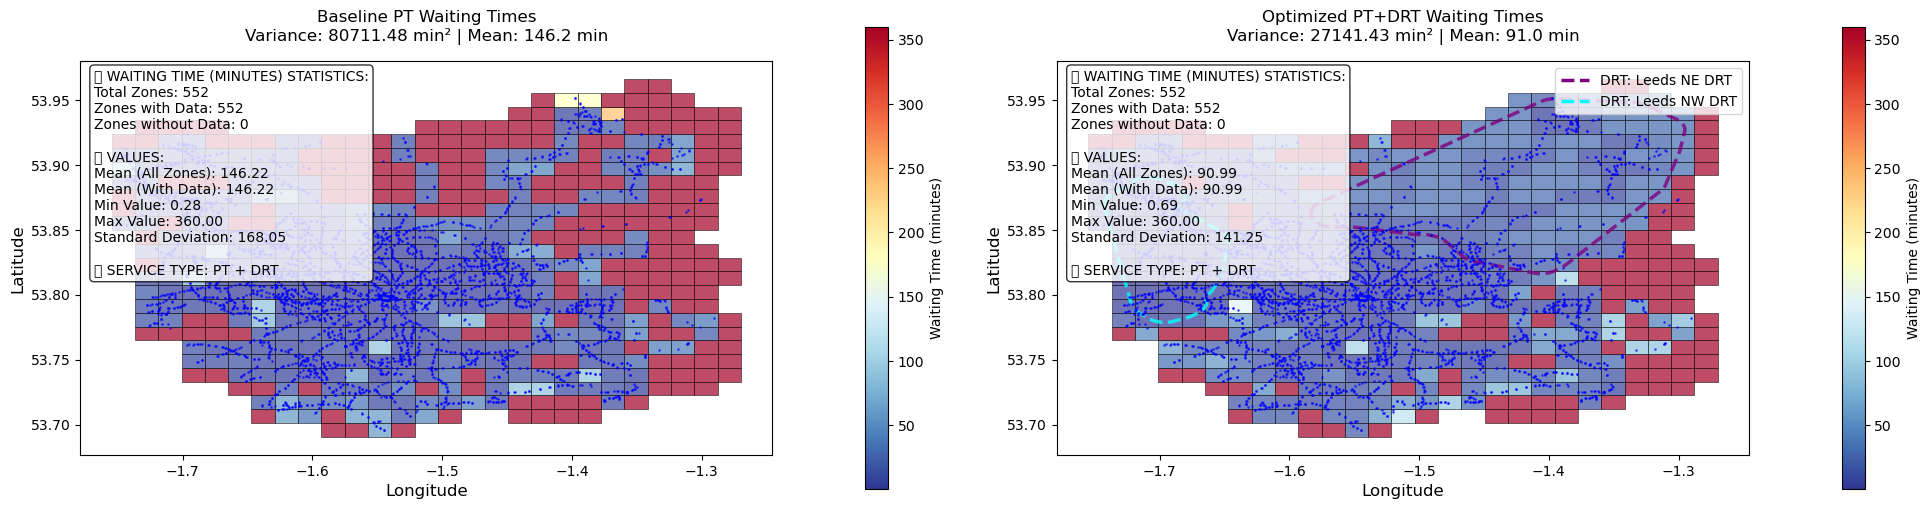


✅ Waiting time optimization visualization completed!
   • Waiting time variance improved by +66.4%
   • Mean waiting time: 146.2 → 91.0 minutes
   • Solution satisfies all constraints: True


In [14]:
# Cell 10: Compare Waiting Time Before/After Optimization using WaitingTimeObjective methods
print("\n=== WAITING TIME COMPARISON ===")

# Decode the optimized waiting time solution
optimized_waiting_solution = result_waiting_drt.best_solution

print(f"📊 WAITING TIME IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_waiting_value:.2f}")
print(f"     Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"     Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

# Calculate waiting times using WaitingTimeObjective's built-in method
baseline_waiting_times = waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = waiting_objective.get_waiting_times_per_zone(optimized_waiting_solution, "average")

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
baseline_variance_waiting = np.var(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
optimized_variance_waiting = np.var(optimized_waiting_times)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Variance: {baseline_variance_waiting:.2f} → {optimized_variance_waiting:.2f} min²")

# Use combined min/max for consistent color scaling
combined_min_waiting = min(baseline_waiting_times.min(), optimized_waiting_times.min())
combined_max_waiting = max(baseline_waiting_times.max(), optimized_waiting_times.max())

print(f"\n🎨 WAITING TIME COLOR SCALE INFO:")
print(f"   Shared color scale: {combined_min_waiting:.1f} - {combined_max_waiting:.1f} minutes")

# Create side-by-side visualization using WaitingTimeObjective's built-in method
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Baseline waiting times
waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0],
    show_stops=True,
    show_drt_zones=False,
    vmin=combined_min_waiting,
    vmax=combined_max_waiting
)
baseline_title = f'Baseline PT Waiting Times\nVariance: {baseline_waiting_value:.2f} min² | Mean: {baseline_mean_waiting:.1f} min'
axes[0].set_title(baseline_title, fontsize=12, pad=15)

# Plot 2: Optimized waiting times
waiting_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1],
    show_stops=True,
    show_drt_zones=True,
    vmin=combined_min_waiting,
    vmax=combined_max_waiting
)
optimized_title = f'Optimized PT+DRT Waiting Times\nVariance: {result_waiting_drt.best_objective:.2f} min² | Mean: {optimized_mean_waiting:.1f} min'
axes[1].set_title(optimized_title, fontsize=12, pad=15)

plt.tight_layout()
plt.show()

print(f"\n✅ Waiting time optimization visualization completed!")
print(f"   • Waiting time variance improved by {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")
print(f"   • Mean waiting time: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} minutes")
print(f"   • Solution satisfies all constraints: {result_waiting_drt.constraint_violations['feasible']}")

#### Visualise service coverage and waiting times

We compare the service coverage and waiting times before and after optimisation to see how they have changed. The DRT service area polygons are overlaid on the maps to show where DRT is operating.


=== COMPREHENSIVE WAITING TIME & SPATIAL COVERAGE COMPARISON ===
📊 WAITING TIME IMPROVEMENTS:
   Objective Value:
     Baseline: 80711.48
     Optimized: 27141.43
     Improvement: +66.4%
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0

   Waiting Time Distribution:
     Mean waiting time: 146.22 → 90.99 min
     Change: -55.23 min

   Vehicle Coverage Distribution:
     Mean vehicles/zone: 26.51 → 23.30
     Change: -3.21 vehicles/zone

🎨 COLOR SCALES:
   Waiting times: 0.3 - 360.0 minutes
   Vehicle coverage: 0.0 - 650.8
   Waiting differences: ±357.7 minutes
   Vehicle differences: ±391.2

📍 Plotting baseline solutions...
📊 Calculating PT-only vehicles per zone...
📊 Calculating PT-only vehic

/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📊 Calculating PT-only vehicles per zone...
📊 Vehicles per zone (average): min=0.0, max=650.75, var=3325.22
📍 Plotting optimized solutions...
📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📊 Calculating PT + DRT vehicles per zone...
🔍 System peak analysis:
   Peak interval: 3 (18-24h)
   Peak total vehicles: 16957.0


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📊 Calculating PT-only vehicles per zone...
📊 Vehicles per zone (average): min=0.0, max=259.5, var=617.26
📍 Plotting improvement differences...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

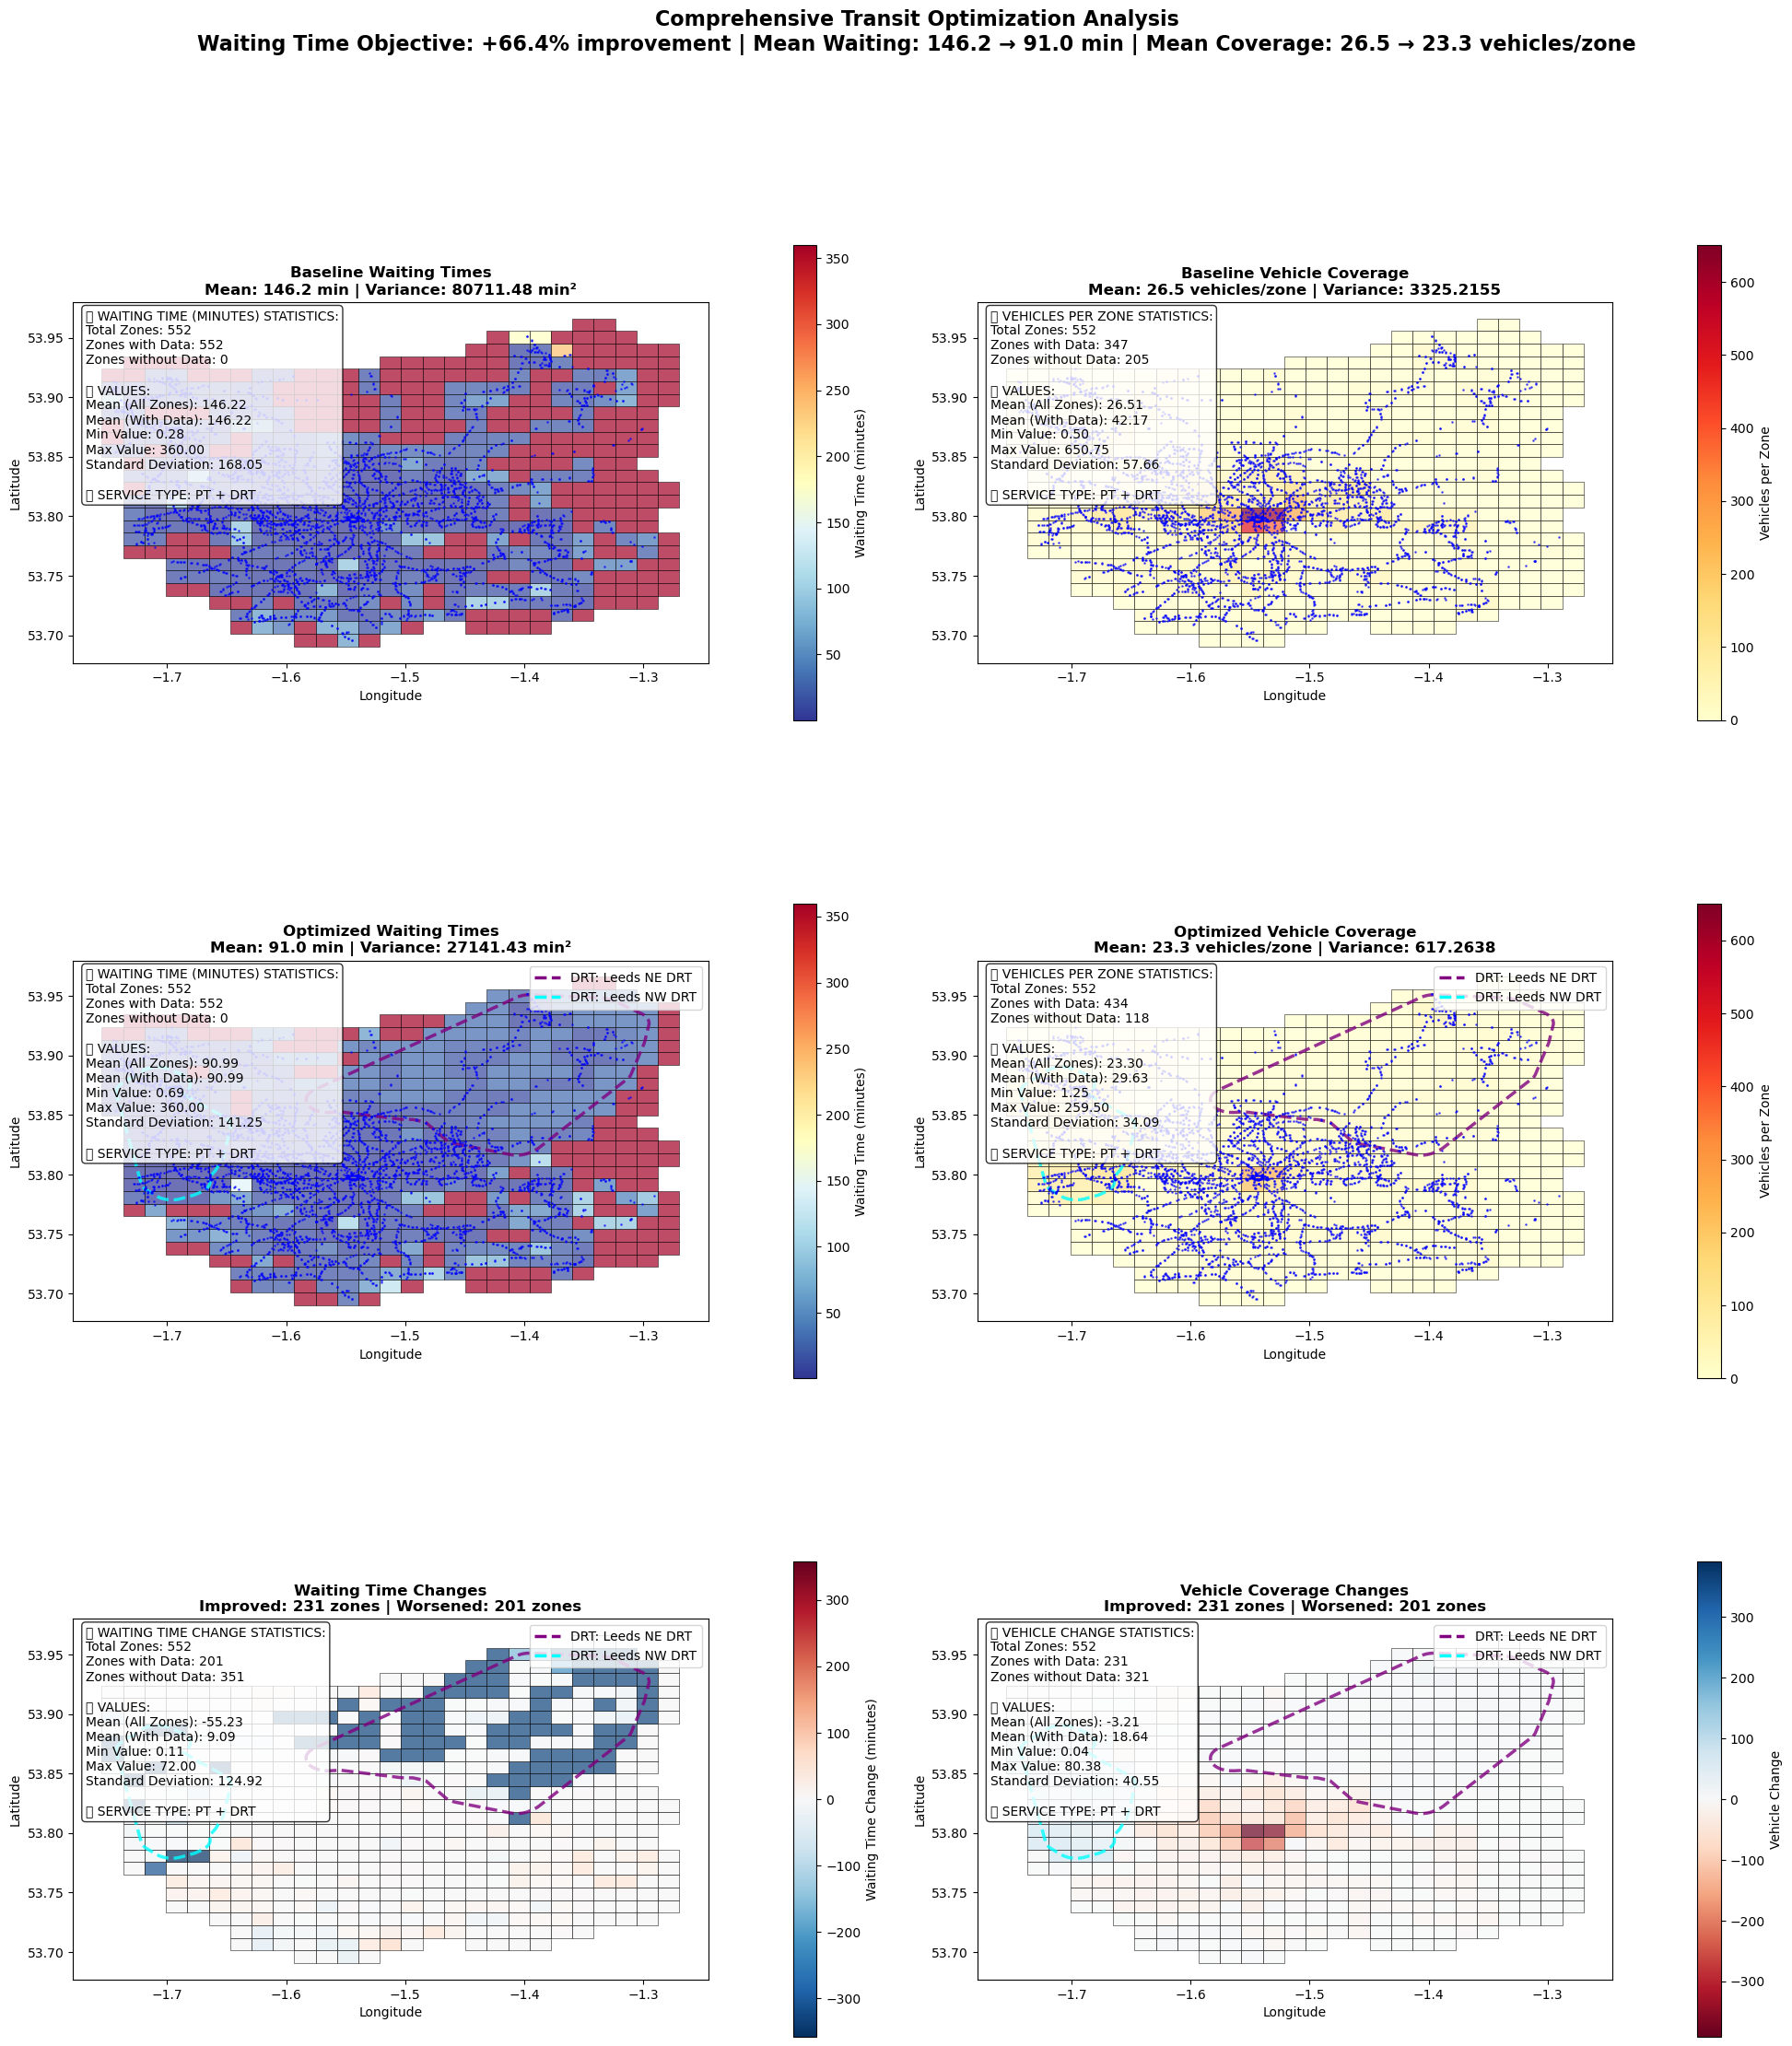


📊 COMPREHENSIVE ANALYSIS SUMMARY:
   🎯 Primary Objective (Waiting Time Variance):
      Baseline: 80711.48 → Optimized: 27141.43
      Improvement: +66.4%

   ⏱️ Waiting Time Distribution:
      Mean: 146.22 → 90.99 minutes (-55.23)
      Zones with improved waiting: 231/552 (41.8%)

   🚌 Vehicle Coverage Distribution:
      Mean: 26.51 → 23.30 vehicles/zone (-3.21)
      Zones with more vehicles: 231/552 (41.8%)

   🏆 Trade-offs Analysis:
      ✅ Waiting time improvement achieved (primary objective)
      ⚖️ Vehicle coverage change: -3.21 vehicles/zone

✅ Comprehensive visualization completed!
   📈 Top row: Baseline solutions
   📈 Middle row: Optimized solutions
   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)
   🚁 DRT zones shown in optimized and difference plots
   ✔️ Solution satisfies constraints: True


In [15]:
print("\n=== COMPREHENSIVE WAITING TIME & SPATIAL COVERAGE COMPARISON ===")

# Decode the optimized waiting time solution
optimized_waiting_solution = result_waiting_drt.best_solution

print(f"📊 WAITING TIME IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_waiting_value:.2f}")
print(f"     Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"     Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

# Calculate waiting times using WaitingTimeObjective's built-in method
baseline_waiting_times = waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = waiting_objective.get_waiting_times_per_zone(optimized_waiting_solution, "average")

# Calculate spatial coverage (vehicles per zone)
baseline_vehicles = coverage_objective.spatial_system._vehicles_per_zone(decoded_solution['pt'], opt_data)['average']
optimized_vehicles = coverage_objective.spatial_system._vehicles_per_zone(optimized_waiting_solution, opt_data)['average']

# Calculate differences
waiting_difference = optimized_waiting_times - baseline_waiting_times  # Negative = improvement
vehicle_difference = optimized_vehicles - baseline_vehicles  # Positive = improvement

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
baseline_mean_vehicles = np.mean(baseline_vehicles)
optimized_mean_vehicles = np.mean(optimized_vehicles)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} min")

print(f"\n   Vehicle Coverage Distribution:")
print(f"     Mean vehicles/zone: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f}")
print(f"     Change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")

# Determine shared color scales for fair comparison
waiting_vmin = min(baseline_waiting_times.min(), optimized_waiting_times.min())
waiting_vmax = max(baseline_waiting_times.max(), optimized_waiting_times.max())
vehicle_vmin = min(baseline_vehicles.min(), optimized_vehicles.min())
vehicle_vmax = max(baseline_vehicles.max(), optimized_vehicles.max())

# For difference plots, use symmetric scale around zero
waiting_diff_max = max(abs(waiting_difference.min()), abs(waiting_difference.max()))
vehicle_diff_max = max(abs(vehicle_difference.min()), abs(vehicle_difference.max()))

print(f"\n🎨 COLOR SCALES:")
print(f"   Waiting times: {waiting_vmin:.1f} - {waiting_vmax:.1f} minutes")
print(f"   Vehicle coverage: {vehicle_vmin:.1f} - {vehicle_vmax:.1f}")
print(f"   Waiting differences: ±{waiting_diff_max:.1f} minutes")
print(f"   Vehicle differences: ±{vehicle_diff_max:.1f}")

# Create comprehensive 3x2 visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# Configure overall title
overall_title = (
    f"Comprehensive Transit Optimization Analysis\n"
    f"Waiting Time Objective: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}% improvement | "
    f"Mean Waiting: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} min | "
    f"Mean Coverage: {baseline_mean_vehicles:.1f} → {optimized_mean_vehicles:.1f} vehicles/zone"
)
fig.suptitle(overall_title, fontsize=16, fontweight='bold', y=0.995)

# Row 1: Baseline Solutions
print("\n📍 Plotting baseline solutions...")

# Row 1, Col 1: Baseline Waiting Times
waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 0],
    show_stops=True,
    show_drt_zones=False,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[0, 0].set_title(f'Baseline Waiting Times\nMean: {baseline_mean_waiting:.1f} min | Variance: {baseline_waiting_value:.2f} min²', 
                     fontsize=12, fontweight='bold')

# Row 1, Col 2: Baseline Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 1],
    show_stops=True,
    show_drt_zones=False,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
baseline_coverage_value = coverage_objective.evaluate(decoded_solution['pt'])
axes[0, 1].set_title(f'Baseline Vehicle Coverage\nMean: {baseline_mean_vehicles:.1f} vehicles/zone | Variance: {baseline_coverage_value:.4f}', 
                     fontsize=12, fontweight='bold')

# Row 2: Optimized Solutions
print("📍 Plotting optimized solutions...")

# Row 2, Col 1: Optimized Waiting Times
waiting_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1, 0],
    show_stops=True,
    show_drt_zones=True,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[1, 0].set_title(f'Optimized Waiting Times\nMean: {optimized_mean_waiting:.1f} min | Variance: {result_waiting_drt.best_objective:.2f} min²', 
                     fontsize=12, fontweight='bold')

# Row 2, Col 2: Optimized Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1, 1],
    show_stops=True,
    show_drt_zones=True,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
optimized_coverage_value = coverage_objective.evaluate(optimized_waiting_solution['pt'])
axes[1, 1].set_title(f'Optimized Vehicle Coverage\nMean: {optimized_mean_vehicles:.1f} vehicles/zone | Variance: {optimized_coverage_value:.4f}', 
                     fontsize=12, fontweight='bold')

# Row 3: Differences (Improvements)
print("📍 Plotting improvement differences...")

# Row 3, Col 1: Waiting Time Difference (Optimized - Baseline)
# Negative values = improvement (shorter waiting times)
zones_with_waiting_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_waiting_diff["waiting_change"] = waiting_difference
zones_geo_waiting = zones_with_waiting_diff.to_crs("EPSG:4326")

zones_geo_waiting.plot(
    ax=axes[2, 0],
    column="waiting_change",
    cmap="RdBu_r",  # Red=increase (worse), Blue=decrease (better)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-waiting_diff_max,
    vmax=waiting_diff_max,
    legend_kwds={
        "label": "Waiting Time Change (minutes)",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 0], opt_data, True)
waiting_stats_text = coverage_objective.spatial_system._create_data_stats_text(waiting_difference, "Waiting Time Change", opt_data)
axes[2, 0].text(0.02, 0.98, waiting_stats_text, transform=axes[2, 0].transAxes, 
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_waiting = np.sum(waiting_difference < 0)
zones_worsened_waiting = np.sum(waiting_difference > 0)
axes[2, 0].set_title(f'Waiting Time Changes\nImproved: {zones_improved_waiting} zones | Worsened: {zones_worsened_waiting} zones', 
                     fontsize=12, fontweight='bold')

# Row 3, Col 2: Vehicle Coverage Difference (Optimized - Baseline)
# Positive values = improvement (more vehicles)
zones_with_vehicle_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_vehicle_diff["vehicle_change"] = vehicle_difference
zones_geo_vehicles = zones_with_vehicle_diff.to_crs("EPSG:4326")

zones_geo_vehicles.plot(
    ax=axes[2, 1],
    column="vehicle_change",
    cmap="RdBu",  # Red=increase (better), Blue=decrease (worse)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-vehicle_diff_max,
    vmax=vehicle_diff_max,
    legend_kwds={
        "label": "Vehicle Change",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 1], opt_data, True)
vehicle_stats_text = coverage_objective.spatial_system._create_data_stats_text(vehicle_difference, "Vehicle Change", opt_data)
axes[2, 1].text(0.02, 0.98, vehicle_stats_text, transform=axes[2, 1].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_vehicles = np.sum(vehicle_difference > 0)
zones_worsened_vehicles = np.sum(vehicle_difference < 0)
axes[2, 1].set_title(f'Vehicle Coverage Changes\nImproved: {zones_improved_vehicles} zones | Worsened: {zones_worsened_vehicles} zones', 
                     fontsize=12, fontweight='bold')

# Add geographic labels to all subplots
for i in range(3):
    for j in range(2):
        axes[i, j].set_xlabel("Longitude", fontsize=10)
        axes[i, j].set_ylabel("Latitude", fontsize=10)
        axes[i, j].set_aspect("equal")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.96)  # Make room for overall title
plt.show()

# Print comprehensive summary
print(f"\n📊 COMPREHENSIVE ANALYSIS SUMMARY:")
print(f"   🎯 Primary Objective (Waiting Time Variance):")
print(f"      Baseline: {baseline_waiting_value:.2f} → Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"      Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

print(f"\n   ⏱️ Waiting Time Distribution:")
print(f"      Mean: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} minutes ({optimized_mean_waiting - baseline_mean_waiting:+.2f})")
print(f"      Zones with improved waiting: {zones_improved_waiting}/{len(baseline_waiting_times)} ({100*zones_improved_waiting/len(baseline_waiting_times):.1f}%)")

print(f"\n   🚌 Vehicle Coverage Distribution:")
print(f"      Mean: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f} vehicles/zone ({optimized_mean_vehicles - baseline_mean_vehicles:+.2f})")
print(f"      Zones with more vehicles: {zones_improved_vehicles}/{len(baseline_vehicles)} ({100*zones_improved_vehicles/len(baseline_vehicles):.1f}%)")

print(f"\n   🏆 Trade-offs Analysis:")
if optimized_mean_waiting < baseline_mean_waiting and optimized_mean_vehicles > baseline_mean_vehicles:
    print("      ✅ Win-Win: Both waiting times decreased AND vehicle coverage increased")
elif optimized_mean_waiting < baseline_mean_waiting:
    print("      ✅ Waiting time improvement achieved (primary objective)")
    print(f"      ⚖️ Vehicle coverage change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")
else:
    print("      ⚠️ Complex trade-offs detected - review spatial patterns above")

print(f"\n✅ Comprehensive visualization completed!")
print(f"   📈 Top row: Baseline solutions")
print(f"   📈 Middle row: Optimized solutions") 
print(f"   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)")
print(f"   🚁 DRT zones shown in optimized and difference plots")
print(f"   ✔️ Solution satisfies constraints: {result_waiting_drt.constraint_violations['feasible']}")